In [1]:
%matplotlib inline
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

# --- ATLAS style ---
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasStyle.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasUtils.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasLabels.C")
ROOT.SetAtlasStyle()

ROOT.EnableImplicitMT()

# --- Load Delphes ---
delphes_dir = "/home/kalelc/research/Delphes-3.5.0/"
status = ROOT.gSystem.Load(delphes_dir + "libDelphes.so")
if status != 0:
    raise RuntimeError("Error: Could not load libDelphes.so")
print("libDelphes.so loaded successfully!")

# Input ROOT file
fdisplaced = delphes_dir + "displacedPhoton/displaced_half_dark_events.root"
fprompt = delphes_dir + "displacedPhoton/prompt_half_dark_events.root"
df_displaced = ROOT.RDataFrame("Delphes", fdisplaced)
df_prompt = ROOT.RDataFrame("Delphes", fprompt)


Applying ATLAS style settings...

libDelphes.so loaded successfully!


In [2]:
def create_particle_dataframe(root_file_path):
    # Load the ROOT file into an RDataFrame
    rdf = ROOT.RDataFrame("Delphes", root_file_path)
    
    # Convert the specified properties to a dictionary of numpy arrays
    particle_dict = rdf.AsNumpy([
        "Event.Number",
        "Photon.PT",
        "Photon.Eta",
        "Photon.Phi",
        "Photon.T",
        "Photon_size",
        "Photon.fUniqueID",
    ])
    
    # Flatten event numbers (scalars, not 1-element arrays)
    event_numbers = [arr[0] for arr in particle_dict["Event.Number"]]
    num_photons = particle_dict["Photon_size"]
    particle_dict["Photon.T"] = [t * 10**9 for t in particle_dict["Photon.T"]]

    
    # Build the DataFrame
    particle_df = pd.DataFrame({
        "EventNumber": event_numbers,
        "NumPhotons": num_photons,
        "PT": particle_dict["Photon.PT"],
        "Eta": particle_dict["Photon.Eta"],
        "Phi": particle_dict["Photon.Phi"],
        "T": particle_dict["Photon.T"],
    })
    
    # Explode so each particle gets its own row
    particle_df = particle_df.explode(["PT", "Eta", "Phi", "T"], ignore_index=True)

    # Sort by EventNumber and reset the index
    particle_df = particle_df.sort_values(by="EventNumber").reset_index(drop=True)
    
    # Filter to only events with at least one photon
    particle_df = particle_df[particle_df["NumPhotons"] > 0]
    
    return particle_df

In [3]:
displaced_particle_df = create_particle_dataframe(fdisplaced)
prompt_particle_df = create_particle_dataframe(fprompt)
displaced_particle_df

,EventNumber,NumPhotons,PT,Eta,Phi,T
1,1,1,56.019508,0.323366,-0.583914,4.416217
2,2,1,45.905617,-0.255704,-2.874639,4.610539
3,3,2,59.00642,0.209569,-1.36837,10.168724
4,3,2,33.105965,1.750007,-0.319087,11.539348
5,4,1,45.928295,-0.23588,-2.851681,4.856971
...,...,...,...,...,...,...
7516,5986,2,80.102142,-0.432837,3.01262,4.269496
7519,5989,1,201.658356,-0.656675,2.958543,4.72005
7521,5991,1,200.032211,-0.652832,2.956488,4.85152
7525,5995,1,48.730186,2.376185,0.558778,12.155753


In [4]:
# Find the intersection of EventNumber values in both dataframes
shared_event_numbers = set(displaced_particle_df["EventNumber"]).intersection(prompt_particle_df["EventNumber"])

# Filter both dataframes to include only shared events
displaced_particle_df = displaced_particle_df[displaced_particle_df["EventNumber"].isin(shared_event_numbers)].reset_index(drop=True)
prompt_particle_df = prompt_particle_df[prompt_particle_df["EventNumber"].isin(shared_event_numbers)].reset_index(drop=True)

displaced_particle_df["Displaced"] = True
prompt_particle_df["Displaced"] = False
combined_df = pd.concat([displaced_particle_df, prompt_particle_df], ignore_index=True)

combined_df

,EventNumber,NumPhotons,PT,Eta,Phi,T,Displaced
0,1,1,56.019508,0.323366,-0.583914,4.416217,True
1,2,1,45.905617,-0.255704,-2.874639,4.610539,True
2,3,2,59.00642,0.209569,-1.36837,10.168724,True
3,3,2,33.105965,1.750007,-0.319087,11.539348,True
4,4,1,45.928295,-0.23588,-2.851681,4.856971,True
...,...,...,...,...,...,...,...
10930,5986,1,83.878456,-0.648045,-0.167291,4.664903,False
10931,5989,1,202.620895,-0.643051,2.95806,4.652164,False
10932,5991,2,128.274002,-0.958687,2.285771,5.75316,False
10933,5991,2,206.637177,-0.633966,2.951602,4.652164,False


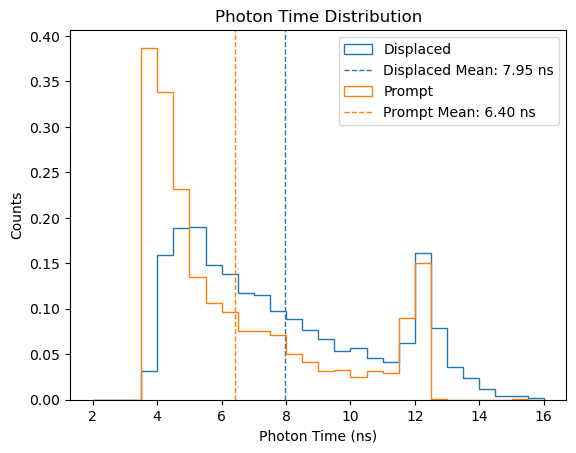

In [5]:
displaced_times = combined_df[combined_df["Displaced"] == True]["T"]
plt.hist(displaced_times, bins=28, range=(2, 16), color='tab:blue', histtype='step', label='Displaced', density=True)
plt.axvline(np.mean(displaced_times), color='tab:blue', linestyle='dashed', linewidth=1, label = f'Displaced Mean: {np.mean(displaced_times):.2f} ns')

prompt_times = combined_df[combined_df["Displaced"] == False]["T"]
plt.hist(prompt_times, bins=28, range=(2, 16), color='tab:orange', histtype='step', label='Prompt', density=True)
plt.axvline(np.mean(prompt_times), color='tab:orange', linestyle='dashed', linewidth=1, label = f'Prompt Mean: {np.mean(prompt_times):.2f} ns')

plt.xlabel('Photon Time (ns)')
plt.ylabel('Counts')
plt.title('Photon Time Distribution')
plt.legend()

plt.savefig("truth_plots/photon_time_comparison.png")

#### Analytic Time

As seen in the plot below, the average transverse momentum of the $\phi$ is 92.6 GeV, and the average eta is ~0, so we can assume that the total momentum of the $\phi$ is 92.6 GeV.

$p = \gamma mv$ -> $v = \frac{pc}{\sqrt{(mc)^2+p^2}}$  \
$v = 0.2 \frac{m}{ns}$

Now, to find the time it should take the $\phi$ to travel the average 1m to decay, divide the distance by the velocity.

$t = \frac{d}{v} = 4.91 ns$

Compare this to the time it takes the photon to travel 1m $t_{\gamma} = \frac{1m}{c} = 3.34 \text{ns}$

Subtracting these, we can get that the expected delay of the photons with the displaced production vertex. **This difference gives a value of 1.57 ns between the displaced photon decays and the prompt photon decays approximately matches our computationally observed number of 1.55 ns.**

$\Delta t = t_{\phi}-t_{\gamma} = 1.57 \text{ns}$

v = 0.20369017630432593 m/ns
t = 4.909416929886383 ns to travel 1m
Time for photons to travel 1 m = 3.33564095198152 ns
Displaced time difference = 1.5737759779048632 ns


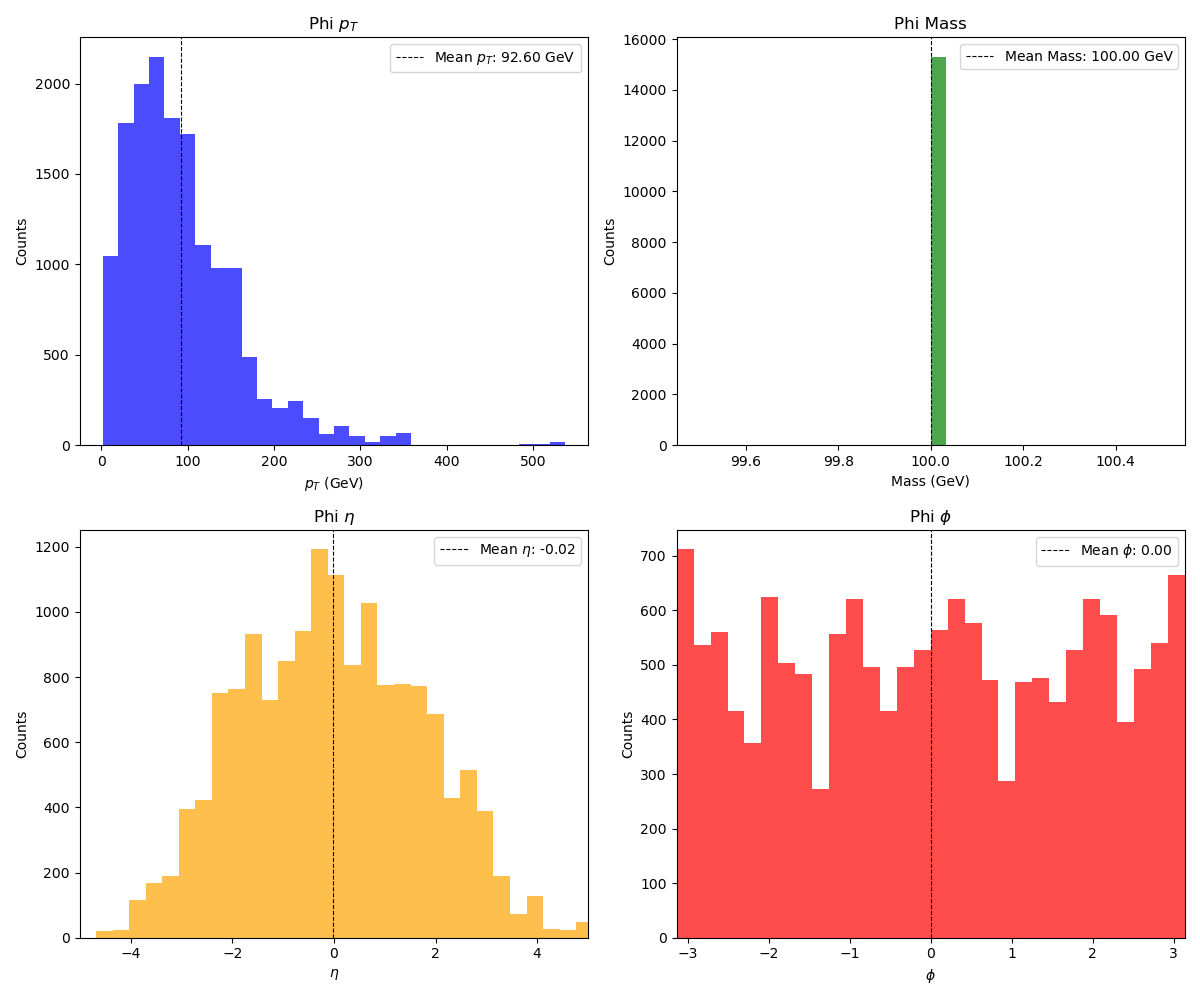

In [6]:
c = 299792458
m = 100 / c**2
p = 92.6 / c

v = (p * c) / np.sqrt((m * c)**2 + p**2)
v *= 10**-9 # convert to m/ns
print(f"v = {v} m/ns")
print(f"t = {1/v} ns to travel 1m")
print(f"Time for photons to travel 1 m = {1 / (c*10**-9)} ns")
print(fr"Displaced time difference = {(1/v) - (1/(c*10**-9))} ns")

Image(filename='truth_plots/truth_phi_info.png', width=400)

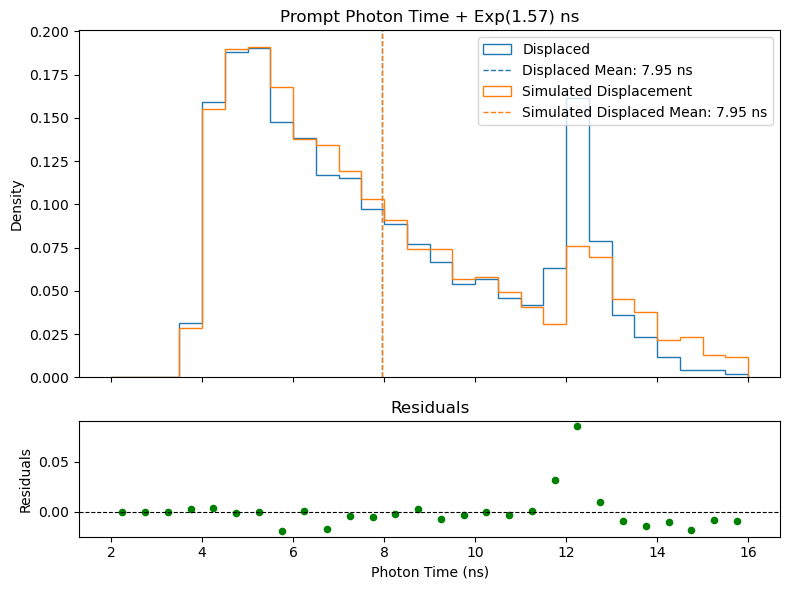

In [7]:
displacement = 1.57

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Top plot: Histogram
bins = 28
range_vals = (2, 16)
hist_displaced, bin_edges = np.histogram(displaced_times, bins=bins, range=range_vals, density=True)
hist_prompt, _ = np.histogram(prompt_times + displacement, bins=bins, range=range_vals, density=True)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

ax1.hist(displaced_times, bins=bins, range=range_vals, color='tab:blue', histtype='step', label='Displaced', density=True)
ax1.axvline(np.mean(displaced_times), color='tab:blue', linestyle='dashed', linewidth=1, label=f'Displaced Mean: {np.mean(displaced_times):.2f} ns')

simulated_displacement = np.random.exponential(displaced_times.mean() - prompt_times.mean(), size=len(prompt_times))
simulated_prompt_times = prompt_times + simulated_displacement
ax1.hist(simulated_prompt_times, bins=bins, range=range_vals, color='tab:orange', histtype='step', label='Simulated Displacement', density=True)
ax1.axvline(np.mean(simulated_prompt_times), color='tab:orange', linestyle='dashed', linewidth=1, label=f'Simulated Displaced Mean: {np.mean(simulated_prompt_times):.2f} ns')

ax1.set_title(f'Prompt Photon Time + Exp({displacement}) ns')
ax1.set_ylabel('Density')
ax1.legend()

# Bottom plot: Residuals
hist_simulated_prompt, _ = np.histogram(simulated_prompt_times, bins=bins, range=range_vals, density=True)
residuals = hist_displaced - hist_simulated_prompt
ax2.scatter(bin_centers, residuals, color='green', s=20)
ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax2.set_xlabel('Photon Time (ns)')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals')

# Adjust layout
plt.savefig("truth_plots/simulated_displacement_comparison.png", bbox_inches='tight')
plt.tight_layout()
plt.show()
